# Exercise 3: Convolutional Neural Networks

Gruppo Stocafisici: Edoardo Antonaci, Angelica Foroni, Francesco Mazza, Leonardo Salicari.

1. Experiment with different architectures (which was left as an open point when “NCONV”
variable was introduced), in particular try at least another version where only one
convolutional layer is introduced instead of two, and where any number of dense layers may
be used, with the global constraint of using a network with at most 600 trainable parameters.
The filter length in the second convolutional layer may be shorter.
Is the number of parameters scaling more quickly by adding Dense layers or Conv1D
layers?
Check which configuration works better by comparing the performances quantitatively.
2. Visualize the “confusion matrix” (look for similar examples in the material available or by
googling)
3. With two convolutional layers, plot also the weights of the second layer and try to see if
regularization may improve the performances by varying the parameter lambda of the L1 or
of the L2 regularization; see lambda in eqs.(43) and (52) in the review. There is also a mixed
version (l1_l2?) that can be tried. Is any value of lambda good? Is there any intermediate
value where the performances of the network are better? Is there any improvement in the
visualization and understanding of the weights in the filters? Note that the regularization we
introduced acts on the w’s, not on the biases. One can also try the equivalent procedure for
biases or for the output of the relu units (see Keras doc.), if there is any reason for
suspecting that it may help. In our case, the logic was to let the weights of the filters go to
zero if not needed, hence that kind of regularization was selected.
4. By reducing the signal-to-noise ratio, namely the amplitude of the external signal in the data
(A) with respect to the step typical size of the jump process, check where the network starts
to fail discriminating the categories.

### Loading dataset
We are going to use the dataset generated during the lecture

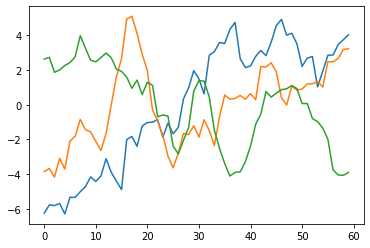

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

name = '_ts_L60_Z12_A12_DX50_bias5_N10000.csv'
xname = 'DATA/x' + name
yname = 'DATA/y' + name

# Dataset
x = np.loadtxt(xname, delimiter=',', dtype=float)
N = x.shape[0]
L = x.shape[1]

# Labels
categ = np.loadtxt(yname, delimiter=',', dtype=int)
y = np.zeros((N, 3 ))
for i in range(N):
    y[i][categ[i]] = 1.

# Removing avg and scaling data
x_avg = np.mean(x, axis=1).reshape(N,1) # average over sample (i.e. over rows)
x = (x - x_avg)/100 # one line to remove avg and scale; faster than a for loop
    
# Training and Validation
# Note, these are view, not copies
train_frac = .8
N_train = int(N*train_frac)
x_train = x[0:N_train,:]
y_train = y[0:N_train,:]
x_val = x[N_train:,:]
y_val = y[N_train:,:]

# Plotting some data
for k in range(3):
    plt.plot(x_train[k])
    
# Reshape for Keras
# Hence adding an extra dim wich correspond to the depth 
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)

input_size = (L,1)

## 1: CNN with different topologies

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras import initializers, regularizers

def create_model(NCONV=1):
    ''' 
    Creates a CNN with different topologies by changing NCONV 
    NCONV == 1 (from baiesi lecture):
        Conv -> AvgPadding -> Conv -> Fattern -> Dense -> Dense (output)
    
    '''
    
    # Defining regulirizer
    reg = regularizers.l1(0.1)

    # Used to initialize kernel 
    ini = initializers.RandomNormal(mean = 0,
                                   stddev = .05)
    
    model = Sequential()
    
    if NCONV == 1:
        model.add( Conv1D(filters=5,
                          kernel_size = 11,                              
                          kernel_initializer = init,
                          kernel_regulizer = reg,
                          activation = 'relu',
                          input_size = input_size
                         ) )
        model.add( AveragePooling1D(5) ) # max pooling size
    
    return model